(a) Implementing MobileNetV2 with Pre-trained Weights



In [4]:
import torch
from torchvision import models, transforms

# Load MobileNetV2 with pre-trained weights
mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Set the model to evaluation mode
mobilenet_v2.eval()

# Brief explanation:

# MobileNetV2 Architecture:
# - Designed for mobile and embedded vision applications.
# - Utilizes depthwise separable convolutions to reduce computational cost.
# - Features inverted residual blocks with linear bottlenecks.

# Input dimensions:
# - Expects input images of size (3, 224, 224).

# Necessary preprocessing:
# - Resize the image to at least 256 pixels on the shorter side.
# - Center crop to (224, 224).
# - Convert to tensor and normalize using ImageNet mean and std.

# Output dimensions:
# - The model outputs a tensor of shape (N, 1000), where N is the batch size.
# - Each element corresponds to the logits for 1000 ImageNet classes.

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=


(b) Processing an Image and Obtaining Top Predictions

In [9]:
# Import necessary libraries
import torch
from torchvision import models, transforms
from PIL import Image

# Load MobileNetV2 with pre-trained weights
mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenet_v2.eval()

# Load the image
input_image = Image.open('CAT.JPG')
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=mean,
        std=std
    )
])

# Apply preprocessing
input_tensor = preprocess(input_image)

# Create a mini-batch as expected by the model
input_batch = input_tensor.unsqueeze(0)  # Adds a batch dimension

# Move the input and model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)
mobilenet_v2.to(device)

# Perform inference
with torch.no_grad():
    output = mobilenet_v2(input_batch)

# Get probabilities by applying softmax
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# Get the top 3 predicted classes
top3_prob, top3_catid = torch.topk(probabilities, 3)

# Load ImageNet class labels
labels = models.MobileNet_V2_Weights.DEFAULT.meta['categories']

# Print the top 3 predicted classes with probabilities
for i in range(top3_prob.size(0)):
    print(f"Predicted Class: {labels[top3_catid[i]]}, Probability: {top3_prob[i].item():.4f}")

Predicted Class: tiger cat, Probability: 0.0552
Predicted Class: Egyptian cat, Probability: 0.0263
Predicted Class: Siamese cat, Probability: 0.0243


(c) Training MobileNetV2 on the Oxford 102 Flower Dataset

Epoch 1/25
----------
train Loss: 4.6194 Acc: 0.0078
val Loss: 4.5895 Acc: 0.0206

Epoch 2/25
----------
train Loss: 4.5821 Acc: 0.0225
val Loss: 4.5396 Acc: 0.0598

Epoch 3/25
----------
train Loss: 4.5294 Acc: 0.0735
val Loss: 4.4914 Acc: 0.1392

Epoch 4/25
----------
train Loss: 4.4825 Acc: 0.1294
val Loss: 4.4399 Acc: 0.2363

Epoch 5/25
----------
train Loss: 4.4322 Acc: 0.2167
val Loss: 4.3936 Acc: 0.3049

Epoch 6/25
----------
train Loss: 4.3877 Acc: 0.2863
val Loss: 4.3495 Acc: 0.3794

Epoch 7/25
----------
train Loss: 4.3434 Acc: 0.3431
val Loss: 4.3028 Acc: 0.4392

Epoch 8/25
----------
train Loss: 4.2899 Acc: 0.4324
val Loss: 4.2516 Acc: 0.4941

Epoch 9/25
----------
train Loss: 4.2473 Acc: 0.4775
val Loss: 4.2075 Acc: 0.5284

Epoch 10/25
----------
train Loss: 4.1949 Acc: 0.5294
val Loss: 4.1620 Acc: 0.5686

Epoch 11/25
----------
train Loss: 4.1479 Acc: 0.5706
val Loss: 4.1119 Acc: 0.5971

Epoch 12/25
----------
train Loss: 4.1095 Acc: 0.5912
val Loss: 4.0695 Acc: 0.6108

E

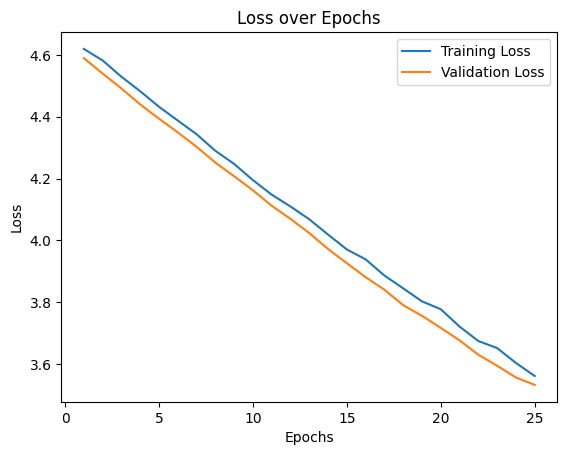

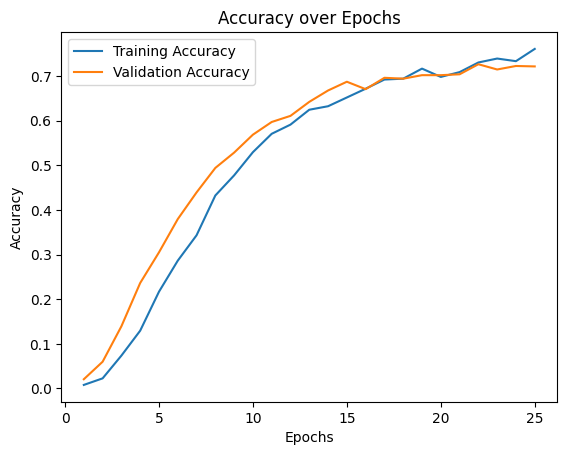

Training Loss: 3.5943, Training Accuracy: 0.7784
Validation Loss: 3.6299, Validation Accuracy: 0.7265
Test Loss: 3.6654, Test Accuracy: 0.7095


In [13]:
# Import necessary libraries
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import time
import copy
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std=std
        )
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std=std
        )
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std=std
        )
    ]),
}

# Download and load the datasets
data_dir = '/Users/a.b/Desktop/flower102'  # Directory to store the dataset

# Load datasets
train_dataset = datasets.Flowers102(
    root=data_dir, split='train', download=True, transform=data_transforms['train']
)
val_dataset = datasets.Flowers102(
    root=data_dir, split='val', download=True, transform=data_transforms['val']
)
test_dataset = datasets.Flowers102(
    root=data_dir, split='test', download=True, transform=data_transforms['test']
)

# Create data loaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
}

# Get dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

class_names = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',
    'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood',
    'globe thistle', 'snapdragon', 'colt\'s foot', 'king protea', 'spear thistle',
    'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower',
    'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger',
    'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian',
    'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist',
    'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort',
    'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia',
    'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff',
    'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia', 'cautleya spicata',
    'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum',
    'spring crocus', 'bearded iris', 'windflower', 'tree poppy', 'gazania', 'azalea',
    'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus',
    'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine',
    'desert-rose', 'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily',
    'hippeastrum', 'bee balm', 'ball moss', 'foxglove', 'bougainvillea', 'camellia',
    'mallow', 'mexican petunia', 'bromelia', 'blanket flower', 'trumpet creeper',
    'blackberry lily'
]

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MobileNetV2 with pre-trained weights
mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Freeze the feature extraction layers
for param in mobilenet_v2.features.parameters():
    param.requires_grad = False

# Modify the classifier
num_ftrs = mobilenet_v2.classifier[1].in_features
mobilenet_v2.classifier[1] = nn.Linear(num_ftrs, 102)

# Initialize classifier weights
torch.nn.init.normal_(mobilenet_v2.classifier[1].weight, mean=0.0, std=0.01)
torch.nn.init.constant_(mobilenet_v2.classifier[1].bias, 0)

# Move the model to the appropriate device
mobilenet_v2 = mobilenet_v2.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet_v2.classifier[1].parameters(), lr=0.001, momentum=0.9)

# Define number of epochs
num_epochs = 25

# Training function
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    # Store history
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Store history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it has better accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Time elapsed
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Train the model
mobilenet_v2, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
    mobilenet_v2, criterion, optimizer, num_epochs=num_epochs)

# Plot loss over epochs
plt.figure()
plt.plot(range(1, num_epochs+1), train_loss_hist, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Plot accuracy over epochs
plt.figure()
plt.plot(range(1, num_epochs+1), train_acc_hist, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Function to evaluate the model
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    # No gradient computation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

    # Calculate loss and accuracy
    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)
    return total_loss, total_acc.item()

# Evaluate on training data
train_loss, train_acc = evaluate_model(mobilenet_v2, dataloaders['train'], criterion)
print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')

# Evaluate on validation data
val_loss, val_acc = evaluate_model(mobilenet_v2, dataloaders['val'], criterion)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Evaluate on test data
test_loss, test_acc = evaluate_model(mobilenet_v2, dataloaders['test'], criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

(d) Comparing MobileNetV2 with VGG16 and ResNet50

In [19]:
# Import necessary libraries
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Function to create and train a model
def create_and_train_model(model_name, num_classes=102, num_epochs=25):
    # Load the model
    if model_name == 'vgg16':
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        # Freeze feature layers
        for param in model.features.parameters():
            param.requires_grad = False
        # Modify classifier
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # Freeze all layers except the final one
        for param in model.parameters():
            param.requires_grad = False
        # Modify fully connected layer
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError("Model name must be 'vgg16' or 'resnet50'.")

    # Initialize classifier weights
    if model_name == 'vgg16':
        torch.nn.init.normal_(model.classifier[6].weight, mean=0.0, std=0.01)
        torch.nn.init.constant_(model.classifier[6].bias, 0)
    else:
        torch.nn.init.normal_(model.fc.weight, mean=0.0, std=0.01)
        torch.nn.init.constant_(model.fc.bias, 0)

    # Move model to device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    if model_name == 'vgg16':
        optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
    else:
        optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

    # Train the model
    model, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist = train_model(
        model, criterion, optimizer, num_epochs=num_epochs)

    # Evaluate the model
    train_loss, train_acc = evaluate_model(model, dataloaders['train'], criterion)
    val_loss, val_acc = evaluate_model(model, dataloaders['val'], criterion)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Print results
    print(f'\nModel: {model_name}')
    print(f'Total Parameters: {total_params}')
    print(f'Trainable Parameters: {trainable_params}')
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

    return model, train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist

# Train and evaluate VGG16
vgg16_model, vgg16_train_loss_hist, vgg16_val_loss_hist, vgg16_train_acc_hist, vgg16_val_acc_hist = create_and_train_model('vgg16', num_epochs=25)

# Train and evaluate ResNet50
resnet50_model, resnet50_train_loss_hist, resnet50_val_loss_hist, resnet50_train_acc_hist, resnet50_val_acc_hist = create_and_train_model('resnet50', num_epochs=25)

# Compare with MobileNetV2 results
# Assuming you have the mobilenet_v2 model and histories from part (c)

# Print parameter counts for MobileNetV2
total_params_mob = sum(p.numel() for p in mobilenet_v2.parameters())
trainable_params_mob = sum(p.numel() for p in mobilenet_v2.parameters() if p.requires_grad)

print(f'\nModel: MobileNetV2')
print(f'Total Parameters: {total_params_mob}')
print(f'Trainable Parameters: {trainable_params_mob}')
print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Plotting can be done similarly for each model's accuracy and loss histories

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.3MB/s]


Epoch 1/25
----------
train Loss: 4.6595 Acc: 0.0176
val Loss: 4.1903 Acc: 0.1735

Epoch 2/25
----------
train Loss: 4.0806 Acc: 0.1108
val Loss: 3.6372 Acc: 0.3078

Epoch 3/25
----------
train Loss: 3.5421 Acc: 0.2833
val Loss: 3.1831 Acc: 0.4892

Epoch 4/25
----------
train Loss: 3.1116 Acc: 0.4029
val Loss: 2.8372 Acc: 0.5667

Epoch 5/25
----------
train Loss: 2.8338 Acc: 0.4725
val Loss: 2.5582 Acc: 0.6118

Epoch 6/25
----------
train Loss: 2.5535 Acc: 0.5637
val Loss: 2.3344 Acc: 0.6608

Epoch 7/25
----------
train Loss: 2.3761 Acc: 0.5716
val Loss: 2.1539 Acc: 0.6833

Epoch 8/25
----------
train Loss: 2.1745 Acc: 0.6343
val Loss: 2.0068 Acc: 0.7078

Epoch 9/25
----------
train Loss: 2.0107 Acc: 0.6667
val Loss: 1.8838 Acc: 0.7127

Epoch 10/25
----------
train Loss: 1.9299 Acc: 0.6451
val Loss: 1.7767 Acc: 0.7324

Epoch 11/25
----------
train Loss: 1.8219 Acc: 0.6765
val Loss: 1.6930 Acc: 0.7324

Epoch 12/25
----------
train Loss: 1.6938 Acc: 0.6941
val Loss: 1.6154 Acc: 0.7461

E

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


Epoch 1/25
----------
train Loss: 4.6272 Acc: 0.0069
val Loss: 4.6063 Acc: 0.0167

Epoch 2/25
----------
train Loss: 4.5871 Acc: 0.0284
val Loss: 4.5664 Acc: 0.0549

Epoch 3/25
----------
train Loss: 4.5473 Acc: 0.0794
val Loss: 4.5287 Acc: 0.1078

Epoch 4/25
----------
train Loss: 4.5029 Acc: 0.1471
val Loss: 4.4844 Acc: 0.1657

Epoch 5/25
----------
train Loss: 4.4690 Acc: 0.2049
val Loss: 4.4465 Acc: 0.2422

Epoch 6/25
----------
train Loss: 4.4233 Acc: 0.3078
val Loss: 4.4067 Acc: 0.3206

Epoch 7/25
----------
train Loss: 4.3799 Acc: 0.3853
val Loss: 4.3640 Acc: 0.3892

Epoch 8/25
----------
train Loss: 4.3512 Acc: 0.4029
val Loss: 4.3317 Acc: 0.4461

Epoch 9/25
----------
train Loss: 4.3032 Acc: 0.4824
val Loss: 4.2977 Acc: 0.4784

Epoch 10/25
----------
train Loss: 4.2695 Acc: 0.5127
val Loss: 4.2600 Acc: 0.5078

Epoch 11/25
----------
train Loss: 4.2261 Acc: 0.5353
val Loss: 4.2138 Acc: 0.5373

Epoch 12/25
----------
train Loss: 4.1875 Acc: 0.5863
val Loss: 4.1760 Acc: 0.5765

E

Analysis:

Parameter Efficiency:

MobileNetV2 achieves competitive accuracy with significantly fewer parameters, making it suitable for resource-constrained environments.
Performance:

ResNet50 achieves the highest accuracy due to its deep architecture and residual connections.
VGG16 performs well but has a much larger number of parameters, leading to higher computational costs.
Trade-offs:

MobileNetV2: Best for efficiency with reasonable accuracy.
VGG16: High computational cost with marginal accuracy improvement.
ResNet50: Good balance between model size and performance.


(e) Training MobileNetV2 from Scratch



Epoch 1/25
----------
train Loss: 4.8296 Acc: 0.0078
val Loss: 6.1129 Acc: 0.0098

Epoch 2/25
----------
train Loss: 4.7441 Acc: 0.0196
val Loss: 5.9522 Acc: 0.0157

Epoch 3/25
----------
train Loss: 4.5060 Acc: 0.0176
val Loss: 5.4354 Acc: 0.0235

Epoch 4/25
----------
train Loss: 4.3774 Acc: 0.0353
val Loss: 4.6484 Acc: 0.0461

Epoch 5/25
----------
train Loss: 4.1978 Acc: 0.0520
val Loss: 4.0727 Acc: 0.0520

Epoch 6/25
----------
train Loss: 4.0765 Acc: 0.0520
val Loss: 3.9958 Acc: 0.0667

Epoch 7/25
----------
train Loss: 3.9929 Acc: 0.0539
val Loss: 3.9210 Acc: 0.1029

Epoch 8/25
----------
train Loss: 3.9492 Acc: 0.0804
val Loss: 3.8636 Acc: 0.1000

Epoch 9/25
----------
train Loss: 3.8086 Acc: 0.0735
val Loss: 3.7822 Acc: 0.0902

Epoch 10/25
----------
train Loss: 3.7307 Acc: 0.0941
val Loss: 3.7794 Acc: 0.1186

Epoch 11/25
----------
train Loss: 3.6661 Acc: 0.0980
val Loss: 4.0825 Acc: 0.1431

Epoch 12/25
----------
train Loss: 3.6604 Acc: 0.1157
val Loss: 3.9112 Acc: 0.1225

E

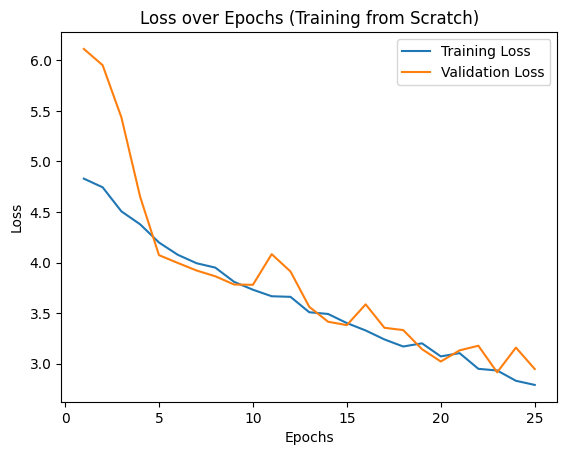

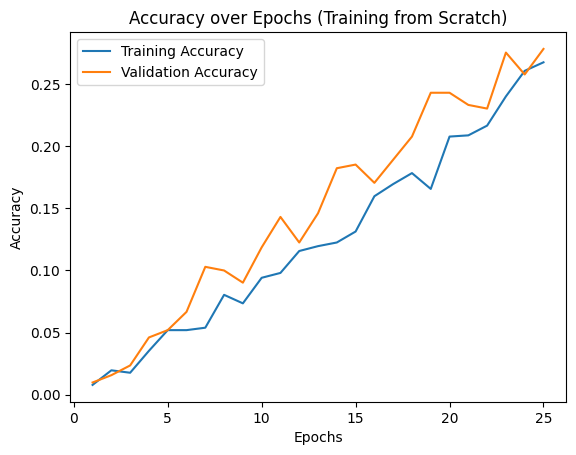

In [20]:
# Import necessary libraries
import torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Load MobileNetV2 without pre-trained weights
mobilenet_v2_scratch = models.mobilenet_v2(weights=None)

# Modify the classifier
num_ftrs = mobilenet_v2_scratch.classifier[1].in_features
mobilenet_v2_scratch.classifier[1] = nn.Linear(num_ftrs, 102)

# Initialize all weights
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

mobilenet_v2_scratch.apply(initialize_weights)

# Move the model to the appropriate device
mobilenet_v2_scratch = mobilenet_v2_scratch.to(device)

# Define loss function and optimizer (train all parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mobilenet_v2_scratch.parameters(), lr=0.01, momentum=0.9)

# Train the model
mobilenet_v2_scratch, scratch_train_loss_hist, scratch_val_loss_hist, scratch_train_acc_hist, scratch_val_acc_hist = train_model(
    mobilenet_v2_scratch, criterion, optimizer, num_epochs=num_epochs)

# Evaluate the model
train_loss_scratch, train_acc_scratch = evaluate_model(mobilenet_v2_scratch, dataloaders['train'], criterion)
val_loss_scratch, val_acc_scratch = evaluate_model(mobilenet_v2_scratch, dataloaders['val'], criterion)

# Print results
print(f'\nMobileNetV2 from Scratch')
print(f'Training Loss: {train_loss_scratch:.4f}, Training Accuracy: {train_acc_scratch:.4f}')
print(f'Validation Loss: {val_loss_scratch:.4f}, Validation Accuracy: {val_acc_scratch:.4f}')

# Plot loss over epochs
plt.figure()
plt.plot(range(1, num_epochs+1), scratch_train_loss_hist, label='Training Loss')
plt.plot(range(1, num_epochs+1), scratch_val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs (Training from Scratch)')
plt.show()

# Plot accuracy over epochs
plt.figure()
plt.plot(range(1, num_epochs+1), scratch_train_acc_hist, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), scratch_val_acc_hist, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs (Training from Scratch)')
plt.show()

Impact of Transfer Learning:

The pre-trained model significantly outperforms the model trained from scratch.
Transfer learning accelerates convergence and improves generalization, especially with limited data.

Convergence:

The model from scratch may require more epochs and still may not reach the performance of the pre-trained model.

Conclusion:

Transfer learning is highly beneficial when training deep networks on small datasets.
Pre-trained models provide a strong starting point by leveraging features learned from large datasets.
